In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision 
from typing import Tuple, Any
from torchvision import datasets, models
import torchvision.transforms as T
import random
import cv2
from PIL import Image
import os

# **Section 1: The Data**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!unzip /content/drive/MyDrive/CS231N/Projects_The_good_stuff/P4GANs/birds_dataset.zip

In [6]:
 base_path = "/content"
 train_path = base_path + "/train"

In [7]:
category_map = {}
train_count = 0
train_images = []

for idx, entry in enumerate(os.listdir(train_path)):
  
  if os.path.isdir(os.path.join(train_path, entry)):
    category_map[entry] = idx
    train_count+= len(os.listdir(train_path+"/"+entry))
  
    for img in os.listdir(train_path+"/"+entry):
    
      train_images.append(train_path+"/"+entry+"/"+img)

print(category_map) # just to see the map 
print(train_count) #verify number of training images
print(train_images[0]) #Verify what the paths look like 

{'AUCKLAND SHAQ': 0, 'ASIAN DOLLARD BIRD': 1, 'FLAME TANAGER': 2, 'SAND MARTIN': 3, 'INDIAN VULTURE': 4, 'PARUS MAJOR': 5, 'MARABOU STORK': 6, 'CRESTED SHRIKETIT': 7, 'AFRICAN CROWNED CRANE': 8, 'AMERICAN COOT': 9, 'BANANAQUIT': 10, 'CROWNED PIGEON': 11, 'FIERY MINIVET': 12, 'JOCOTOCO ANTPITTA': 13, 'PUFFIN': 14, 'RED FACED CORMORANT': 15, 'SNOWY EGRET': 16, 'KILLDEAR': 17, 'CAMPO FLICKER': 18, 'BLACKBURNIAM WARBLER': 19, 'KAKAPO': 20, 'HEPATIC TANAGER': 21, 'DUSKY ROBIN': 22, 'BANDED BROADBILL': 23, 'SORA': 24, 'MAGPIE GOOSE': 25, 'WHITE NECKED RAVEN': 26, 'GLOSSY IBIS': 27, 'FLAME BOWERBIRD': 28, 'AFRICAN OYSTER CATCHER': 29, 'NOISY FRIARBIRD': 30, 'ROUGH LEG BUZZARD': 31, 'FAIRY PENGUIN': 32, 'CASPIAN TERN': 33, 'CRESTED COUA': 34, 'MALEO': 35, 'PHILIPPINE EAGLE': 36, 'BALD IBIS': 37, 'GRANDALA': 38, 'CHARA DE COLLAR': 39, 'VIOLET TURACO': 40, 'ANDEAN SISKIN': 41, 'TURKEY VULTURE': 42, 'EASTERN ROSELLA': 43, 'VIOLET GREEN SWALLOW': 44, 'MYNA': 45, 'ALTAMIRA YELLOWTHROAT': 46, 'RUFUO

In [8]:
class birds_dataset(Dataset):
  
  def __init__(self, images, birds_classes, transform):
    
    super().__init__()
    self.images = images 
    self.class_map = birds_classes 
    self.transforms = transform
  
  def __getitem__(self, index):
    
    img_path = self.images[index]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    
    image = Image.fromarray(image.astype(np.uint8))
    
    label = img_path.split("/")[-2]
    label = self.class_map[label]   

    if self.transforms:
      image = self.transforms(image)
    
    return image, label 

In [9]:
train_transform = T.Compose([T.Resize((128, 128))])
train_set = birds_dataset(train_images, category_map, train_transform)

0


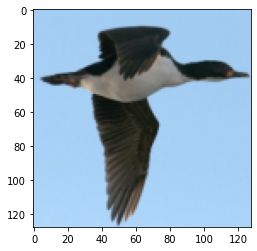

In [10]:
plt.imshow(train_set[1][0]) #128x128 seems like a good resolution feasibility and quality wise 
print(train_set[1][1]) #label verification 

In [11]:
train_transform = T.Compose([T.Resize((128, 128)), T.ToTensor()])
train_set = birds_dataset(train_images, category_map, train_transform)

# **Section 2: The Model**

In [12]:
generator_features = 128 
discriminator_features = 128 
prior_size = 100 

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
class Generator(nn.module):

  def __init__(self, net_name):
    #define computational graph 
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        nn.ConvTranspose2d(prior_size, generator_features * 8, 4, bias = False)
        nn.BatchNorm2d(generator_features*8)
    )
  
  def forward(self, x):
    #define forward pass